In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_length_tiled_sorted_extra_margin"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 78,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 60,
 'long_margin': 36,
 'margin': 121,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 140,
 'short_margin': 43,
 'start_cap': 121,
 'start_consonant': 171,
 'start_lower': 79,
 'start_the': 57,
 'start_vowel': 29}


In [2]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["short_margin"]
tags_false = ["long_margin"]
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

43 36


In [3]:
pprint(positives)

[{'input': 'PEACE BEGINS WITH A SMILE.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
           'gpt4']},
 {'input': 'CHANGE IS THE ONLY CONSTANT.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
           'gpt4']},
 {'input': 'LAUGHTER IS THE BEST MEDICINE.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
           'gpt4']},
 {'input': 'simplicity is the ultimate sophistication.',
  'label': True,
  'tags': ['odd_words',
           'short',
           'sentence',
           'start_lower',
           'start_consonant',
           'short_margin',
           'gpt4'

In [4]:
pprint(negatives)

[{'input': 'New York City is known as the Big Apple.',
  'label': False,
  'tags': ['start_cap',
           'city',
           'odd_words',
           'long',
           'proper_noun',
           'long_margin',
           'sentence',
           'start_consonant',
           'gpt4']},
 {'input': 'The Statue of Liberty stands tall in New York.',
  'label': False,
  'tags': ['start_cap',
           'city',
           'odd_words',
           'long',
           'proper_noun',
           'long_margin',
           'sentence',
           'start_consonant',
           'start_the',
           'gpt4']},
 {'input': 'the aroma of freshly baked cookies fills the kitchen.',
  'label': False,
  'tags': ['long',
           'odd_words',
           'long_margin',
           'sentence',
           'start_lower',
           'start_consonant',
           'start_the',
           'gpt4',
           'all_lower']},
 {'input': 'THE SILENCE OF NATURE IS VERY REAL. IT SURROUNDS YOU...',
  'label': False,
  'tags':

In [6]:
sample_counts = [3, 5, 10, 15]
response_jsons = []
sort_len = lambda x: len(x.split())
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir, max_test_ct=50, tiled=True, prompt_sort_by=sort_len)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:106: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:107: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:110: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:111: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [2]:
sample_counts = [3, 5, 10, 15]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [3]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.6363636363636364,
  'correct': 42,
  'corrupted': 0,
  'false': 33,
  'in_context_count': 3,
  'incorrect': 24,
  'mismatch': 0,
  'precision': 0.6666666666666666,
  'recall': 0.5454545454545454,
  'total': 66,
  'true': 33},
 {'accuracy': 0.7580645161290323,
  'correct': 47,
  'corrupted': 0,
  'false': 31,
  'in_context_count': 5,
  'incorrect': 15,
  'mismatch': 0,
  'precision': 0.7857142857142857,
  'recall': 0.7096774193548387,
  'total': 62,
  'true': 31},
 {'accuracy': 0.7884615384615384,
  'correct': 41,
  'corrupted': 0,
  'false': 26,
  'in_context_count': 10,
  'incorrect': 11,
  'mismatch': 0,
  'precision': 0.7777777777777778,
  'recall': 0.8076923076923077,
  'total': 52,
  'true': 26},
 {'accuracy': 0.8095238095238095,
  'correct': 34,
  'corrupted': 0,
  'false': 21,
  'in_context_count': 15,
  'incorrect': 8,
  'mismatch': 0,
  'precision': 0.7241379310344828,
  'recall': 1.0,
  'total': 42,
  'true': 21}]


In [4]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                   correct  mismatch  incorrect  corrupted  test_total
in_context_count                                                      
3                 0.636364       0.0   0.363636        0.0    0.956522
5                 0.758065       0.0   0.241935        0.0    0.898551
10                0.788462       0.0   0.211538        0.0    0.753623
15                0.809524       0.0   0.190476        0.0    0.608696


Text(0.5, 1.0, 'Short (<5) vs Long (>9) Tiled (n=69, T=1)')

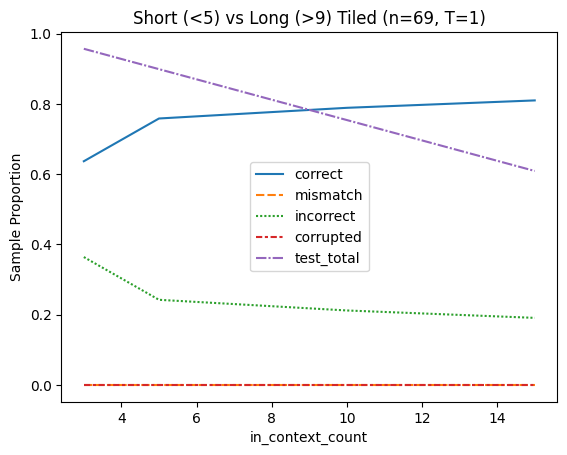

In [8]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
df.drop(columns=["precision"], inplace=True)
df.drop(columns=["recall"], inplace=True)
df.drop(columns=["true"], inplace=True)
df.drop(columns=["false"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

for col in df.columns:
    if col in ["total", "in_context_count", "precision", "recall"]:
        continue
    df[col] /= df["total"]
df["total"] /= total_samples
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Short (<5) vs Long (>9) Tiled (n={total_samples}, T=1)")